In [1]:
# cell for importing packages for the first time
# import Pkg; Pkg.add("StaticArrays")
# import Pkg; Pkg.add("Revise")




   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


┌ Warning: Some registries failed to update:
│     — /Users/avdorodn/.julia/registries/General — failed to fetch from repo
└ @ Pkg.Types /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.4/Pkg/src/Types.jl:1131
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [2]:
using Plots

using StaticArrays


push!(LOAD_PATH, pwd())

module PhysConst
    export CL,Gr,QE,MSOL,MSUN,ARAD,SGMB,RGAS,
            PC,RSUN,RSUN,YR,MSOLYR,GAM53,KPE,PARSEC,KPE,KPD,M_MW
    CL = 2.997925E10;
    Gr = 6.67384E-8; 
    QE=4.80325E-10;
    MSOL = 1.989E33;
    MSUN = 1.989E33;

    ARAD = 7.56464E-15; 
    SGMB = ARAD*CL/4

    RGAS = 8.31E7; 
    PC = 3.085678E18;
    MP = 1.672661E-24; 
    M_U = 1.660531E-24
    RSOL = 6.95E10
    RSUN = 6.95E10
    YR = 365*24*3600.
    MSOLYR = 1.989e33/YR

    GAM = 5/3.

    KPE = 0.4
    PARSEC=3.0E18
    KPD = 10.

    M_MW=1.

    tst=1

end



Main.PhysConst

In [3]:

#-------------------------------------- STEP 1 -------------------------------------- #


# module SpaceGrid


using StaticArrays
import Base.@kwdef

    @kwdef struct SGridPar
        
        Nfreq = 1 ; # ν - N bins 
        Nang = 3
        N_fre_ang = Nfreq*Nang

        Nactive = 4;
    
        nghost = 1 #N of ghost cells at every boundary.
            
        Nx = Nactive;   # N of active cells
        Ny = Nactive;
        Nz = Nactive;
        
        Nxtot = Nx +  2*nghost;
        Nytot = Ny +  2*nghost;
        Nztot = Nz +  2*nghost;
    
        is = 1 + nghost; 
        ie = Nxtot -nghost;        

        js = 1 + nghost;  
        je = Nytot - nghost;
        
        ks = 1 + nghost;
        ke = Nztot - nghost;
    
        
        x1s = -1.
        x1e = 1.
    
        x2s = -2.
        x2e = 2.

        x3s = -3.
        x3e = 3.
        
    end

    @kwdef struct RGridPar
        Nang = 2
    
        Nfreq = 1   
    
    end


sg= SGridPar()

@show rad = RGridPar()


x1 = Array{Float64}(undef, sg.Nxtot)
x2 = Array{Float64}(undef, sg.Nytot)
x3 = Array{Float64}(undef, sg.Nztot)

x1b = Array{Float64}(undef, sg.Nxtot)
x2b = Array{Float64}(undef, sg.Nytot)
x3b = Array{Float64}(undef, sg.Nztot)


@time ir = zeros(Float64, sg.N_fre_ang, sg.Nx, sg.Ny, sg.Nz); # radiation intensity



function MakeGrid(x1, x2, x3, x1b, x2b, x3b, sg)  

    # add check sizes
    
    xtmp = range(sg.x1s, sg.x1e; length = sg.Nxtot - 2sg.nghost)
    
#     @show sg.is, sg.ie sg.Nx sg.nghost size(xtmp) size(x1) size(sg.is:sg.ie) size(2:2)
    
    x1[sg.is:sg.ie] .= xtmp[:] 
    x1[sg.is-1] = 2*x1[sg.is]- x1[sg.is+1]
    x1[sg.ie+1] = 2*x1[sg.ie] -x1[sg.ie-1]

    xtmp = range(sg.x2s, sg.x2e; length = sg.Nytot - 2sg.nghost)    

    x2[sg.js:sg.je] .= xtmp[:]     
    x2[sg.js-1] = 2*x2[sg.js]- x2[sg.js+1]
    x2[sg.je+1] = 2*x2[sg.je] -x2[sg.je-1]

    xtmp = range(sg.x3s, sg.x3e; length = sg.Nztot - 2sg.nghost)    

    x3[sg.ks:sg.ke] .= xtmp[:]     
    x3[sg.ks-1] = 2*x3[sg.ks]- x3[sg.ks+1]
    x3[sg.ke+1] = 2*x3[sg.ke] -x3[sg.ke-1]
    
    
    x1b[1] = x1[1] - 0.5(x1[sg.is]-x1[1])    
    for i in sg.is:(sg.ie+1)
        x1b[i] = x1[i-1] + 0.5(x1[i]-x1[i-1])
    end

    x2b[1] = x2[1] - 0.5(x2[sg.js]-x2[1])    
    for j in sg.js:(sg.je+1)
        x2b[j] = x2[j-1] + 0.5(x2[j]-x2[j-1])
    end

    x3b[1] = x3[1] - 0.5(x3[sg.ks]-x3[1])    
    for k in sg.ks:(sg.ke+1)
        x3b[k] = x3[k-1] + 0.5(x3[k]-x3[k-1])
    end
    
    
    
end


MakeGrid(x1,x2,x3,x1b,x2b,x3b,sg)
@show x3
@show x3b

        
# end



rad = RGridPar() = RGridPar(2, 1)
  0.014040 seconds (28.44 k allocations: 1.506 MiB)
x3 = [-5.0, -3.0, -1.0, 1.0, 3.0, 5.0]
x3b = [-6.0, -4.0, -2.0, 0.0, 2.0, 4.0]


6-element Array{Float64,1}:
 -6.0
 -4.0
 -2.0
  0.0
  2.0
  4.0

In [4]:
const IX = 1
const IY = 2
const IZ = 3

const BIGNUMBER = 10.0^50


# mutable struct SegmentData{
#  /*! cell data along the trajectory */
#   /*!  current index of cell along the ray, phi index is the same */
#   /*! if the source is symmetrical */
#   int i,k;    
#   float dl; //length element    
# }SegmentData;

RayCellInd1 = Array{Int32}(undef,1)
RayCellInd2 = Array{Int32}(undef,1)
RayCellInd3 = Array{Int32}(undef,1)

push!(RayCellInd1, 1)

RayCellInd1 .=0
RayCellInd2 .=0
RayCellInd3 .=0


# create array of ray directions, mu, for every ijk cell (nx,ny,nz) components
# for every ray; 
# nang - number of rays per cell 



# RayData = Array of ( (iCross, jCross, kCross), NcrossCells,(istart, jstart, kstart)=3)
# NcrossCells=3
# @time RayData = zeros(3,  zeros(3),  3)





  0.010179 seconds (12.56 k allocations: 689.676 KiB)


(nx, ny, nz) = (0.0, 1.0, 0.0)
x2 = [-3.3333333333333335, -2.0, -0.6666666666666666, 0.6666666666666666, 2.0, 3.3333333333333335]
x2b = [-4.0, -2.666666666666667, -1.3333333333333333, 0.0, 1.3333333333333335, 2.666666666666667]
norm3 = [0.0, 1.0, 0.0]
ijk_pos = [2, 2, 2]


3-element Array{Int64,1}:
 2
 2
 2

In [12]:

import LinearAlgebra

@time norm = zeros(Float64, rad.Nang, 3, sg.Nx, sg.Ny, sg.Nz);
distToNextCell = fill(BIGNUMBER,3)


# @show size(norm);

norm[1, IX, :, :, :] .= 0
norm[1, IY, :, :, :] .= -1
norm[1, IZ, :, :, :] .= 0

# ijk_pos = MVector{3,Int64}(0,0,0)
ijk_pos = Array{Int64}(undef,3)



ijk_pos .= [sg.is, sg.je, sg.ie]

ijk_tmp = [0, 0, 0]
ijk_max = [ sg.ie+1, sg.je+1, sg.ke+1 ] #max index 
ijk_min = [ sg.is, sg.js, sg.ks ] #min index

norm3 = [norm[1, IX, 1, 1, 1], norm[1, IY, 1, 1, 1] , norm[1, IZ, 1, 1, 1]]


norm3=LinearAlgebra.normalize(norm3)
@show norm3


# should replace 1/norm just in case when Float norm==0.
#          one2norm_i = max(abs())

xbi_zip = [x1b, x2b, x3b]



@show ijk_pos
x3c = [ x1[ijk_pos[IX]], x2[ijk_pos[IY]], x3[ijk_pos[IZ]] ]
@show x3c

@show x1
@show x1b

@show x2
@show x2b

@show x3
@show x3b
# @show xbi_zip[2]

iter=1
dist = 0.0

# xc = 0

xn = Array{Float64}(undef, 3) .= x3c

itermax = 2sg.Nx

for iter in 1:itermax #max length, may be smaller than actual

@show iter

  distToNextCell .= BIGNUMBER

# function FirstTimeTraceGridCalcOneLongRay()

    for (n_it, norm_i ) in enumerate(norm3) #QUESTION: maybe iter over pre-calclulated 1/norms

    
      xc = x3c[n_it] 
        
         if iter > 1 
            
            itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, norm3[n_it])
            
# @show itmp, iter
  
            xn[n_it] = xbi_zip[n_it][itmp]                                            
            
          
         elseif iter==1 #first step from the middle of the cell
            
            if norm_i>0                
               itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, norm3[n_it])                     
            elseif norm_i <0               
                itmp = ijk_tmp[n_it] = ijk_pos[n_it]  #belongs to the same index                                
            else                
                itmp = ijk_pos[n_it]            
            end
          
            xn[n_it] = xbi_zip[n_it][itmp]
            
         end
        
  
         if norm_i != 0                      
            distToNextCell[n_it] = abs((xn[n_it] - xc)/norm3[n_it])
         else
            distToNextCell[n_it]=BIGNUMBER
         end


    println("iter= ",iter," xn=", xn, " ===> ", "distToNextCell[",n_it,"]=",distToNextCell[n_it])
        

    
    end #for loop over norm_i     

        posIndxToUpdate = argmin(distToNextCell)
        dist = distToNextCell[posIndxToUpdate]



    ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one

println("ijk_pos[posIndxToUpdate = ", posIndxToUpdate, "]",  "  =  ",   ijk_pos[posIndxToUpdate]  )


xn .= x3c + norm3*dist
x3c .= xn
    
    
println("xn=", xn)
    if ijk_pos[posIndxToUpdate] == ijk_max[posIndxToUpdate] || ijk_pos[posIndxToUpdate] == ijk_min[posIndxToUpdate] || ijk_pos[posIndxToUpdate] == 1 || iter > 100 
        break; 
    end      

   
end #over ray






  0.000013 seconds (3 allocations: 3.219 KiB)
norm3 = [0.0, -1.0, 0.0]
ijk_pos = [2, 5, 5]
x3c = [-1.0, 2.0, 3.0]
x1 = [-1.6666666666666667, -1.0, -0.3333333333333333, 0.3333333333333333, 1.0, 1.6666666666666667]
x1b = [-2.0, -1.3333333333333335, -0.6666666666666666, 0.0, 0.6666666666666667, 1.3333333333333335]
x2 = [-3.3333333333333335, -2.0, -0.6666666666666666, 0.6666666666666666, 2.0, 3.3333333333333335]
x2b = [-4.0, -2.666666666666667, -1.3333333333333333, 0.0, 1.3333333333333335, 2.666666666666667]
x3 = [-5.0, -3.0, -1.0, 1.0, 3.0, 5.0]
x3b = [-6.0, -4.0, -2.0, 0.0, 2.0, 4.0]
iter = 1
iter= 1 xn=[-1.3333333333333335, 2.0, 3.0] ===> distToNextCell[1]=1.0e50
iter= 1 xn=[-1.3333333333333335, 1.3333333333333335, 3.0] ===> distToNextCell[2]=0.6666666666666665
iter= 1 xn=[-1.3333333333333335, 1.3333333333333335, 2.0] ===> distToNextCell[3]=1.0e50
ijk_pos[posIndxToUpdate = 2]  =  5
xn=[-1.0, 1.3333333333333335, 3.0]
iter = 2
iter= 2 xn=[-0.6666666666666666, 1.3333333333333335, 3.0] ===>

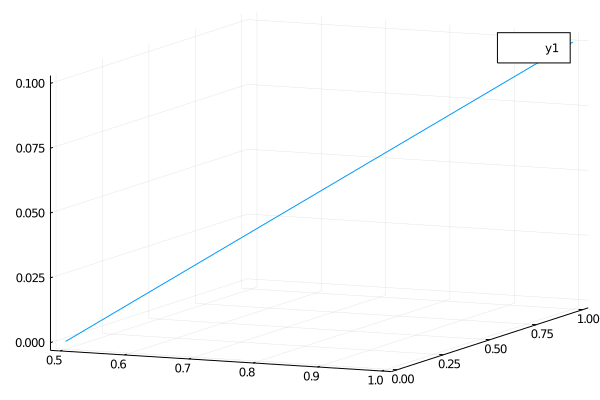

Main.debugByPlot

In [58]:
module debugByPlot

using Plots
# x= LinRange(0,30,10)

# import 

x = [0.5, 1.]
y = [0., 1.]
z = [0., 0.1];


plt=plot3d(x,y,z)



end


In [47]:
# function mtest()
# L = M = N = Int(5e2);

# vec_vec_vec = Array{Array{Vector}}(L);

# for i = 1:L vec_vec_vec[i] = [zeros(N) for j = 1:M] end;

# vec_mat = Array{Matrix}(L);

# fill!(vec_mat, rand(M, N));

# arr = rand(L, M, N);

# @time  for i = 1:L for j = 1:M for k = 1:N vec_vec_vec[i][j][k] += 1; end; end; end; 

# @time  for i = 1:L for j = 1:M for k = 1:N vec_mat[i][j,k] += 1; end; end; end; 

# @time  for k = 1:N for j = 1:M for i = 1:L arr[i,j,k] += 1; end; end; end; 

# end
# mtest()

MethodError: MethodError: no method matching Array{Array{Array{T,1} where T,N} where N,N} where N(::Int64)
Closest candidates are:
  Array{Array{Array{T,1} where T,N} where N,N} where N(!Matched::UndefInitializer, !Matched::Int64) where T at boot.jl:419
  Array{Array{Array{T,1} where T,N} where N,N} where N(!Matched::UndefInitializer, !Matched::Int64, !Matched::Int64) where T at boot.jl:420
  Array{Array{Array{T,1} where T,N} where N,N} where N(!Matched::UndefInitializer, !Matched::Int64, !Matched::Int64, !Matched::Int64) where T at boot.jl:421
  ...

In [45]:
copysign(1, 0)

1

In [53]:
xn = yn =5
yn=4
xn

5

In [54]:
yn

4

In [ ]:
 d